## Frozen Lake

In [1]:
import numpy as np
import gym
from gym import wrappers
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Duplicate key in file '/Users/naziultalukder/.matplotlib/matplotlibrc', line 2 ('backend: PyQt5')
Duplicate key in file '/Users/naziultalukder/.matplotlib/matplotlibrc', line 3 ('backend: TkAgg')


In [2]:
# environment  = 'FrozenLake8x8-v1'
from gym.envs.toy_text import frozen_lake
map_size = 8
np.random.seed(65)
# map_size^2 = state_size
custom_map = frozen_lake.generate_random_map(size=map_size, p=0.8)
custom_map

env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery = True)
# env = gym.make("FrozenLake-v1", desc=None)

# env = gym.make(frozen_lake.FrozenLakeEnv, desc=custom_map)
# env = gym.make(environment)
env = env.unwrapped
desc = env.unwrapped.desc

In [3]:
import numpy as np
import gym
from gym import wrappers


def run_episode(env, policy, gamma = 1.0, render = False):
    obs = env.reset()[0]
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _, _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward


def evaluate_policy(env, policy, gamma = 1.0,  n = 100):
    scores = [
            run_episode(env, policy, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

def extract_policy(v, gamma = 1.0):
    policy = np.zeros(env.nrow * env.ncol)
    for s in range(env.nrow * env.ncol):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for next_sr in env.P[s][a]:
                # next_sr is a tuple of (probability, next state, reward, done)
                p, s_, r, _ = next_sr
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy


def value_iteration(env, gamma = 1.0):
    v = np.zeros(env.nrow * env.ncol)  # initialize value-function
    max_iterations = 100000
    eps = 1e-20
    for i in range(max_iterations):
        prev_v = np.copy(v)
        for s in range(env.nrow * env.ncol):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(4)] 
            v[s] = max(q_sa)
        if (np.sum(np.fabs(prev_v - v)) <= eps):
            # print ('Value-iteration converged at iteration# %d.' %(i+1))
            break
    return v, i+1

### Policy Iteration

In [4]:
def compute_policy_v(env, policy, gamma=1.0):
    v = np.zeros(env.nrow * env.ncol)
    eps = 1e-10
    while True:
        prev_v = np.copy(v)
        for s in range(env.nrow * env.ncol):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
    return v

def policy_iteration(env, gamma = 1.0):
    policy = np.random.choice(4, size=(env.nrow * env.ncol))  # initialize a random policy
    max_iterations = 200000
    gamma = 1.0
    for i in range(max_iterations):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        if (np.all(policy == new_policy)):
            # print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        policy = new_policy
    return policy, i+1


### Plotting

In [5]:
def plot_policy_map(title, policy, map_desc, color_map, direction_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, policy.shape[1]), ylim=(0, policy.shape[0]))
    font_size = 'x-large'
    if policy.shape[1] > 16:
        font_size = 'small'
    plt.title(title)
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            y = policy.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i,j]])
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, direction_map[policy[i, j]], weight='bold', size=font_size,
                           horizontalalignment='center', verticalalignment='center', color='w')


    plt.axis('off')
    plt.xlim((0, policy.shape[1]))
    plt.ylim((0, policy.shape[0]))
    plt.tight_layout()
    plt.savefig(f'{title}.png')
    plt.show()

def colors_lake():
    return {
        b'S': 'magenta',
        b'F': 'silver',
        b'H': 'red',
        b'G': 'green',
    }

def directions_lake():
    return {
        3: u'\u2191',
        2: u'\u2192',
        1: u'\u2193',
        0: u'\u2190'
    }

In [6]:
def plot_iteration(title, value_iter=False):
    
    gamma_vals = np.linspace(0.9,0.9999,20)
    np.random.seed(42)


    all_time=[0]*len(gamma_vals)
    all_gamma=[0]*len(gamma_vals)
    all_iter=[0]*len(gamma_vals)
    all_scores=[0]*len(gamma_vals)

    for i, gamma in enumerate(gamma_vals):
        st=time.time()
        if value_iter:
            best_policy_val, k = value_iteration(env, gamma = gamma)
            best_policy = extract_policy(best_policy_val, gamma)
            scores = evaluate_policy(env, best_policy, gamma = gamma)
            
        else:
            best_policy, k = policy_iteration(env, gamma = gamma)
            scores = evaluate_policy(env, best_policy, gamma = gamma)        
        all_time[i]=time.time()-st
        all_gamma[i]=gamma
        all_scores[i]=np.mean(scores)
        all_iter[i] = k

    figure, axes = plt.subplots(1, 3, figsize=(12, 5))


    sns.scatterplot(ax= axes[0], x=all_gamma, y=all_time)
    sns.lineplot(ax= axes[0], x=all_gamma, y=all_time)

    sns.scatterplot(ax= axes[1], x=all_gamma, y=all_scores)
    sns.lineplot(ax= axes[1], x=all_gamma, y=all_scores)


    sns.scatterplot(ax= axes[2], x=all_gamma, y=all_iter)
    sns.lineplot(ax= axes[2], x=all_gamma, y=all_iter)
    

    axes[0].set(xlabel = 'Gammas', ylabel = 'Execution Time (s)', title= 'Execution Time')
    axes[1].set(xlabel = 'Gammas', ylabel = 'Rewards', title= 'Reward')
    axes[2].set(xlabel = 'Gammas', ylabel = 'Iterations', title= 'Iteration')



    plt.savefig(title)
    plt.show()
    return best_policy

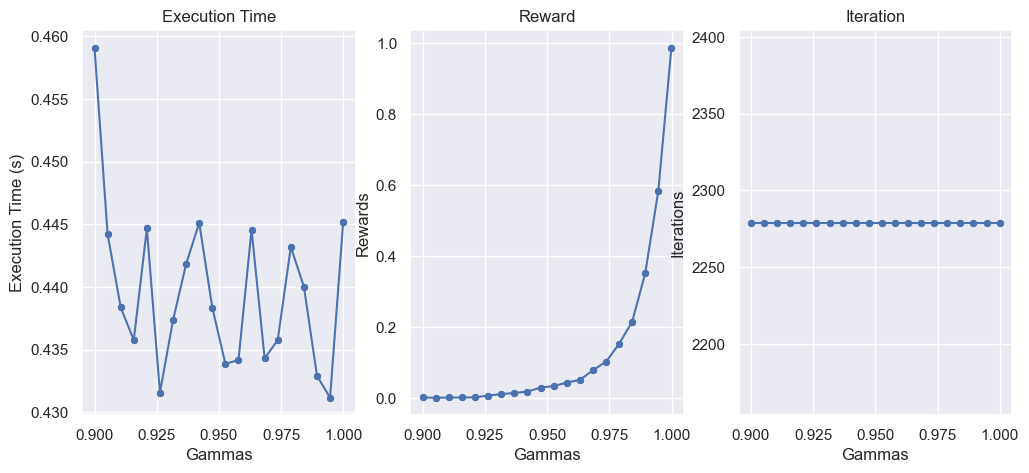

In [7]:
vi_policy = plot_iteration('value_it.png', True)

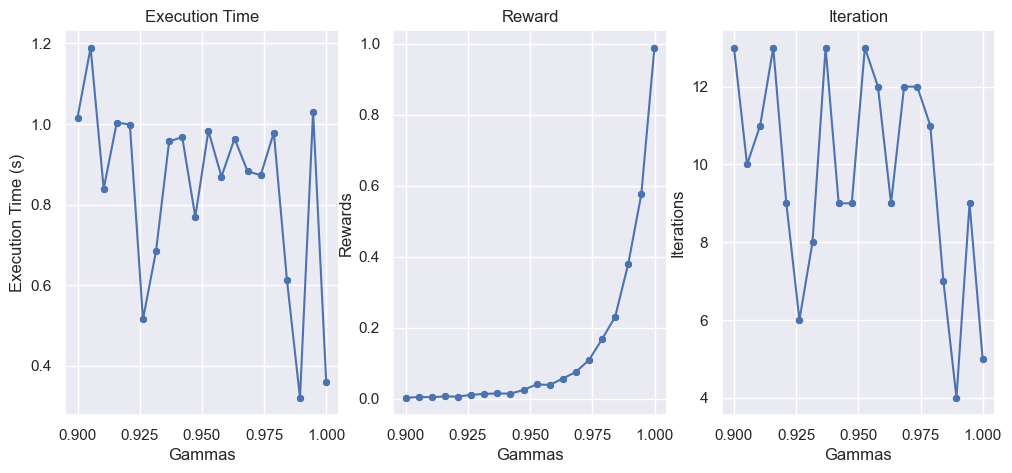

In [8]:
pi_policy = plot_iteration('policy_it.png', False)

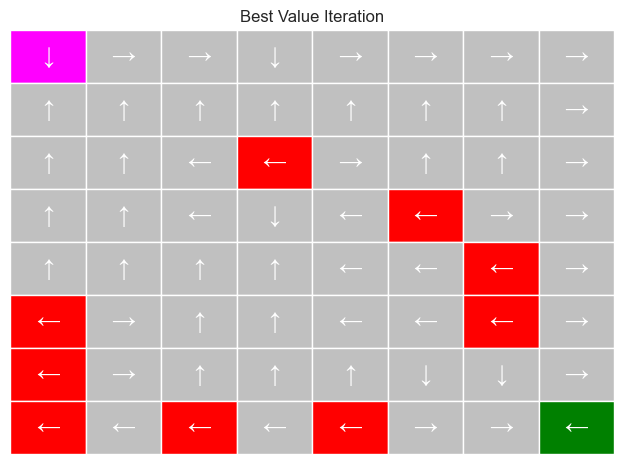

In [9]:
plot_policy_map('Best Value \
Iteration' , vi_policy.reshape(map_size,map_size), desc, colors_lake(), directions_lake())

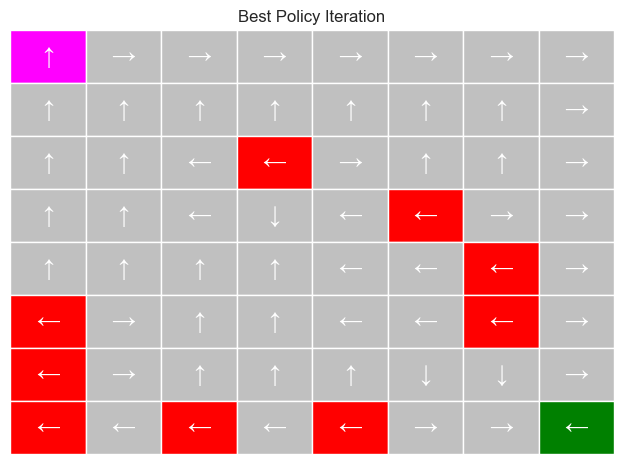

In [10]:
plot_policy_map('Best Policy \
Iteration' , pi_policy.reshape(map_size,map_size), desc, colors_lake(), directions_lake())

In [11]:
def policy_it_conv(env):
    pol_score = []
    it = []
    policy = np.random.choice(4, size=(env.nrow * env.ncol))  # initialize a random policy
    max_iterations = 200000
    gamma = 0.999
    for i in range(max_iterations):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        if (np.all(policy == new_policy)):
            # print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        policy = new_policy
        policy_score = evaluate_policy(env, policy, gamma)
        pol_score.append(policy_score)
        it.append(i+1)
    return pol_score, it

In [12]:
def value_it_conv(env):
    v = np.zeros(env.nrow * env.ncol)  # initialize value-function
    max_iterations = 100000
    gamma = 0.999
    eps = 1e-20
    
    all_scores = []
    all_iter = []
    for i in range(max_iterations):
        prev_v = np.copy(v)
        for s in range(env.nrow * env.ncol):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(4)] 
            v[s] = max(q_sa)
        if (np.sum(np.fabs(prev_v - v)) <= eps):
            # print ('Value-iteration converged at iteration# %d.' %(i+1))
            break
        curr_pol = extract_policy(v, gamma)
        scores = evaluate_policy(env, curr_pol, gamma = gamma)
        all_scores.append(scores)
        all_iter.append(i+1)
        
    return all_scores, all_iter

In [13]:
def plot_convergence():
    pol_score, pol_it = policy_it_conv(env)
    val_score, val_it = value_it_conv(env)
    
    figure, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    sns.scatterplot(ax= axes[0], x=pol_it, y=pol_score)
    sns.lineplot(ax= axes[0], x=pol_it, y=pol_score)

    sns.scatterplot(ax= axes[1], x=val_it, y=val_score)
    sns.lineplot(ax= axes[1], x=val_it, y=val_score)


    axes[0].set(xlabel = 'Iterations', ylabel = 'Average Rewards', title= 'Policy Iteration')
    axes[1].set(xlabel = 'Iterations', ylabel = 'Average Rewards', title= 'Value Iteration')


    plt.savefig('convergence_plot.png')
    plt.show()
    
    

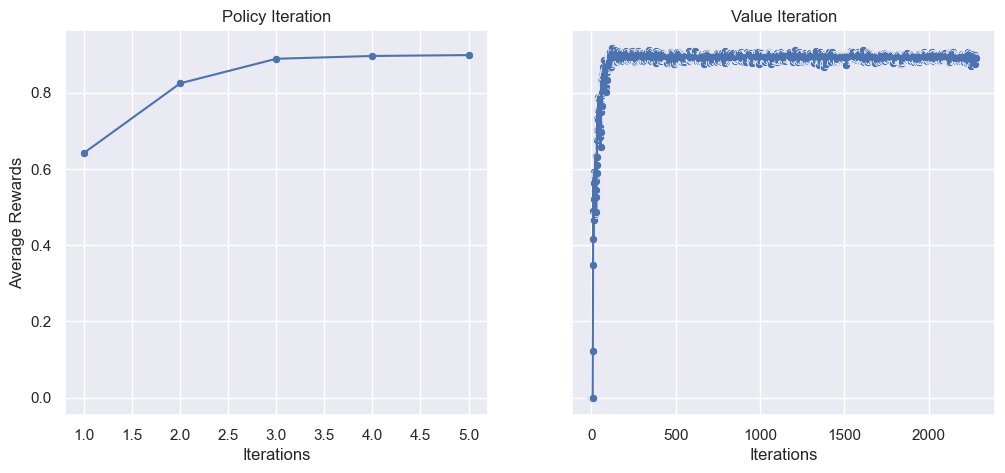

In [14]:
plot_convergence()

In [15]:
from gym.envs.toy_text import frozen_lake
map_size = 20
np.random.seed(65)
custom_map = frozen_lake.generate_random_map(size=map_size, p=0.8)

env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery = True)

env = env.unwrapped
desc = env.unwrapped.desc

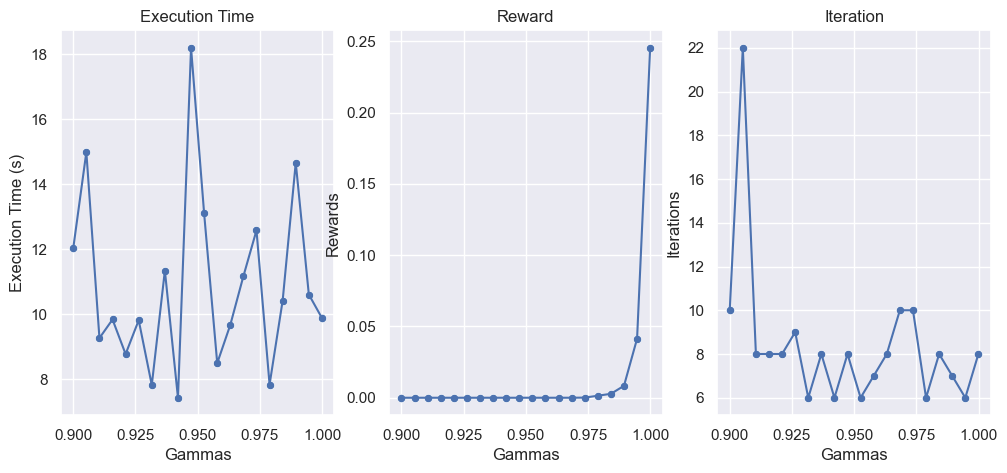

In [16]:
pi_policy = plot_iteration('policy_it_20.png', False)

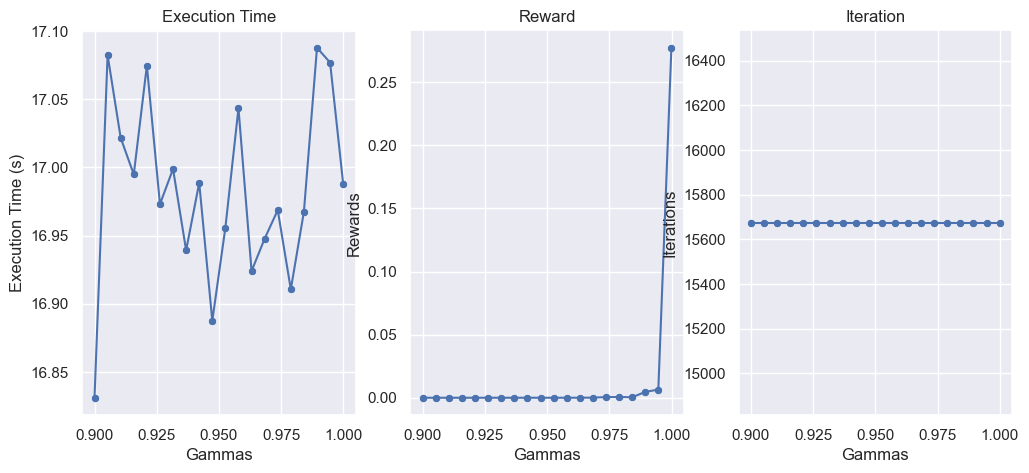

In [17]:
vi_policy = plot_iteration('value_it_20.png', True)

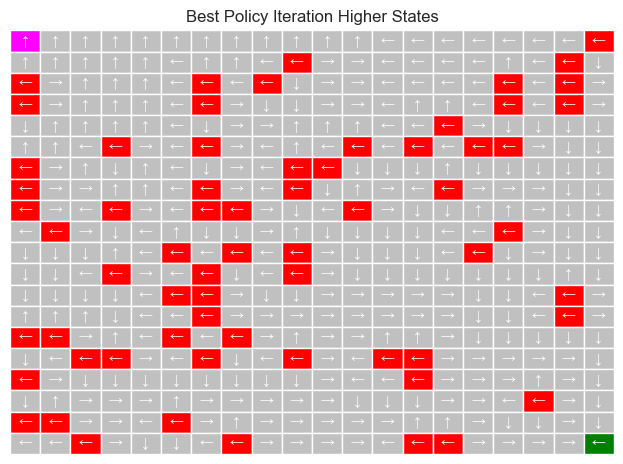

In [18]:
plot_policy_map('Best Policy \
Iteration Higher States' , pi_policy.reshape(map_size,map_size), desc, colors_lake(), directions_lake())

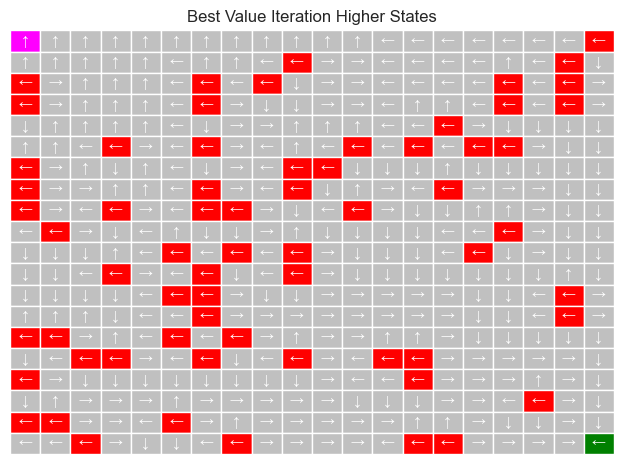

In [19]:
plot_policy_map('Best Value \
Iteration Higher States' , vi_policy.reshape(map_size,map_size), desc, colors_lake(), directions_lake())

## Forest Management

In [20]:
import mdptoolbox.example
import numpy as np
from hiive.mdptoolbox import mdp
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.patches
import random
import time

In [21]:
def run_episodes(policy, S, R, p, num_episodes, num_resets):
    rew_arr = []
    for y in range(num_resets):
        forest_state = 0
        tot_rew = 0
        for x in range(num_episodes):
            forest_state = min(forest_state, S - 1)
            if np.random.rand(1) <= p:
                forest_state = -1
            else:
                tot_rew += R[forest_state][policy[forest_state]]
                if policy[forest_state] == 1:
                    forest_state = -1
            forest_state += 1
        rew_arr.append(tot_rew)
    return np.mean(rew_arr)

In [22]:
def policy_iter(size, title):
    seed_val = 65
    np.random.seed(seed_val)
    random.seed(seed_val)

    S = size
    r1 = 5  # The reward when the forest is in its oldest state and action ‘Wait’ is performed
    r2 = 10 # The reward when the forest is in its oldest state and action ‘Cut’ is performed
    p = 0.1
    

    P, R = mdptoolbox.example.forest(S=S, r1=r1, r2=r2, p=p)  # Defaults left the same

    epsilons = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]

    gammas = [0.1, 0.2, 0.4, 0.5, 0.8, 0.9, 0.99, 0.999]
    # gammas = [0.999]


    best_eps = 0
    best_gam = 0


    best_rew = -1
    best_pol_arr_pi = []
    g_cnt = 0
    e_cnt = 0

    rewards_arr = []
    iters_arr = []
    time_arr = []

    for g in gammas:
        e_cnt = 0
        best_pol = []
        best_rew = -1

        pi = mdp.PolicyIteration(P, R, gamma=g)
        pi.run()
        rew = run_episodes(pi.policy, S, R, p, 1000, 100)
        if rew > best_rew:
            best_rew = rew
            best_pol = pi.policy
            best_gam = g

        rewards_arr.append(rew)
        iters_arr.append(pi.iter)
        time_arr.append(pi.time)
        e_cnt += 1
        best_pol_arr_pi.append(list(best_pol))
        g_cnt += 1

    mean_val = [i["Mean V"] for i in pi.run_stats]
    error = [i["Error"] for i in pi.run_stats]
    reward = [i["Reward"] for i in pi.run_stats]

    fig, ax = plt.subplots()
    ax.plot(mean_val, label='Mean V')
    ax.plot(error, label='Error')
    ax.plot(reward, label='Reward')
    ax.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Counts')
    plt.title("Policy Iteration")
    plt.savefig(f'{title}_analysis.png')
    plt.show()

    cmap = colors.ListedColormap(['forestgreen', 'grey'])
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.title("PI Policy")
    gammas.reverse()
    ax.set_yticklabels(gammas)
    plt.xticks(fontsize=15)
    ax.tick_params(left=False)  # remove the ticks
    plt.xlabel('State')
    plt.ylabel('Gamma')
    plt.pcolor(best_pol_arr_pi[::-1], cmap=cmap, edgecolors='k', linewidths=0)
    plt.savefig(f'{title}_policy.png')
    plt.show()
    
    return best_gam, rewards_arr, len(iters_arr), sum(time_arr), best_pol_arr_pi

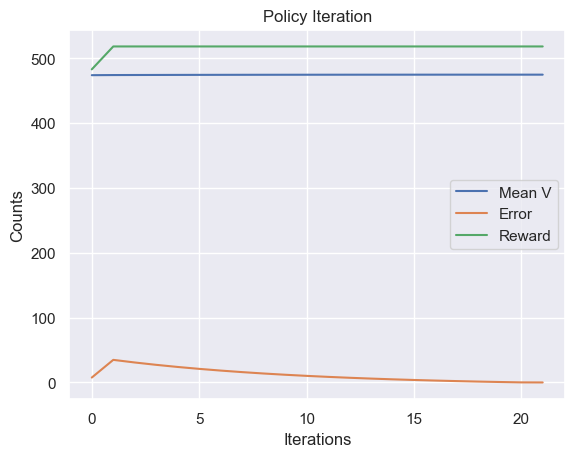

/var/folders/hm/psq79zp10blbxnxgz7xxgx0r0000gn/T/ipykernel_1161/145418701.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(gammas)


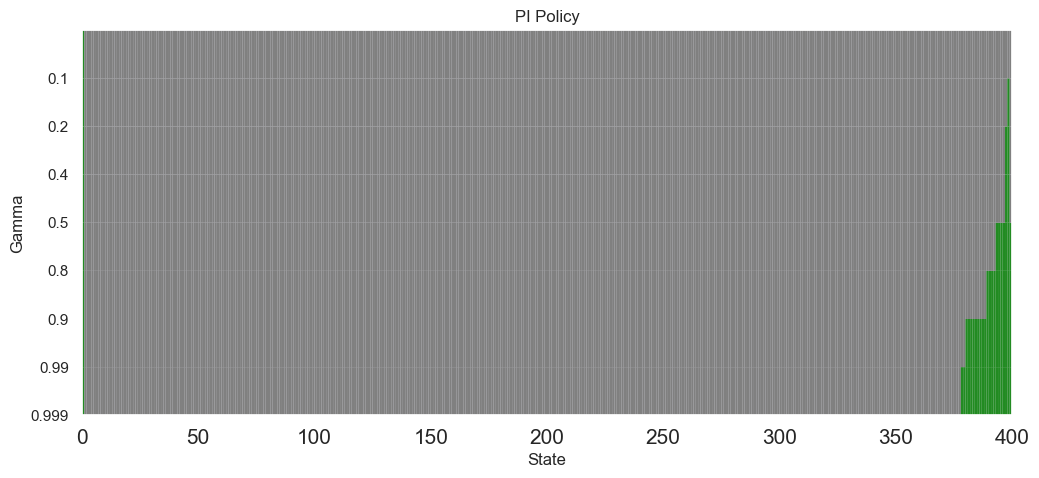

0.999

In [23]:
g, r, i, t, bpl = policy_iter(400, '40_forest')
g

In [24]:
def value_iteration(size, title):
    seed_val = 65
    np.random.seed(seed_val)
    random.seed(seed_val)

    S = size
    r1 = 5  # The reward when the forest is in its oldest state and action ‘Wait’ is performed
    r2 = 10  # The reward when the forest is in its oldest state and action ‘Cut’ is performed
    p = 0.1

    P, R = mdptoolbox.example.forest(S=S, r1=r1, r2=r2, p=p)  # Defaults left the same

    # epsilons = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    epsilons = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]

    gammas = [0.1, 0.2, 0.4, 0.5, 0.8, 0.9, 0.99, 0.999]

    best_gam = 0
    best_eps = 0


    best_rew = -1
    best_pol_arr_vi = []
    g_cnt = 0
    e_cnt = 0

    rewards_arr = []
    iters_arr = []
    time_arr = []

    for g in gammas:
        e_cnt = 0
        best_pol = []
        best_rew = -1

        for e in epsilons:
            pi = mdp.ValueIteration(P, R, gamma=g, epsilon=e)
            pi.run()
            rew = run_episodes(pi.policy, S, R, p, 1000, 100)
            if rew > best_rew:
                best_rew = rew
                best_pol = pi.policy

                best_gam = g
                best_eps = e


            rewards_arr.append(rew)
            iters_arr.append(pi.iter)
            time_arr.append(pi.time)
            e_cnt += 1
        best_pol_arr_vi.append(list(best_pol))
        g_cnt += 1

    mean_val = [i["Mean V"] for i in pi.run_stats]
    error = [i["Error"] for i in pi.run_stats]
    reward = [i["Reward"] for i in pi.run_stats]



    fig, ax = plt.subplots()
    ax.plot(mean_val, label='Mean V')
    ax.plot(error, label='Error')
    ax.plot(reward, label='Reward')
    ax.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Counts')
    plt.title("Value Iteration")
    plt.savefig(f'{title}_analysis.png')
    plt.show()

    cmap = colors.ListedColormap(['forestgreen', 'grey'])
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.title("VI Policy")
    gammas.reverse()
    ax.set_yticklabels(gammas)
    plt.xticks(fontsize=15)
    ax.tick_params(left=False)  # remove the ticks
    plt.xlabel('State')
    plt.ylabel('Gamma')
    plt.pcolor(best_pol_arr_vi[::-1], cmap=cmap, edgecolors='k', linewidths=0)
    plt.savefig(f'{title}_policy.png')
    plt.show()
    
    return best_gam, rewards_arr, best_eps, sum(time_arr), best_pol_arr_vi

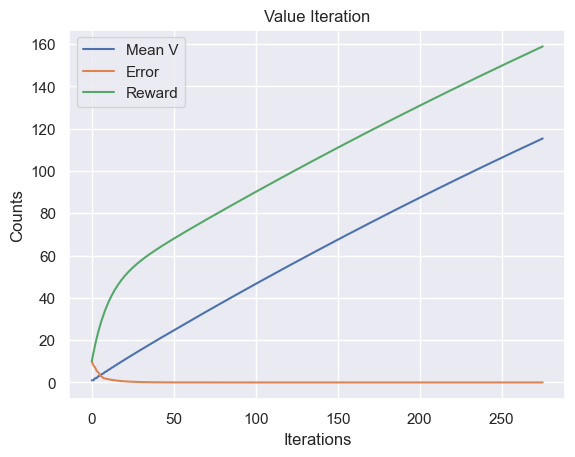

/var/folders/hm/psq79zp10blbxnxgz7xxgx0r0000gn/T/ipykernel_1161/643589763.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(gammas)


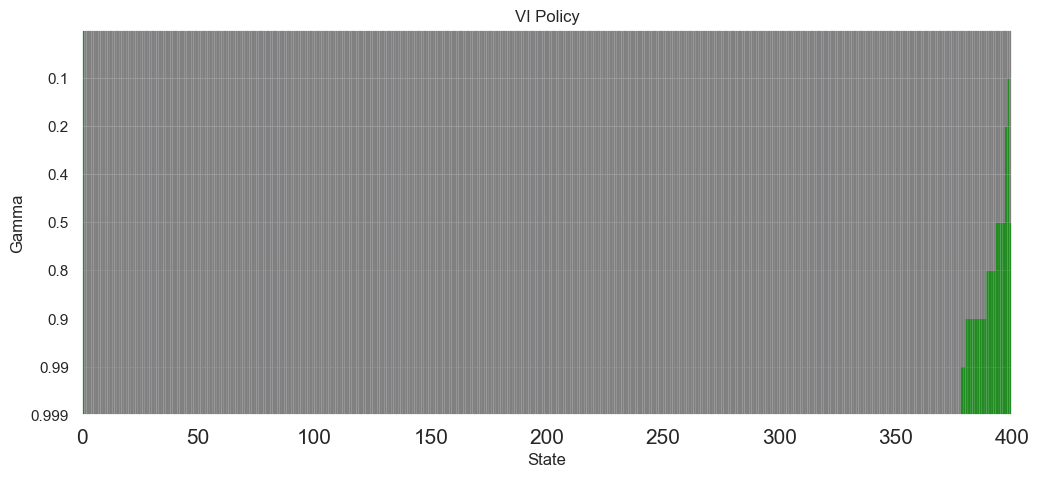

0.999

In [25]:
g2, r2, eps, t2, bpl2 = value_iteration(400, '40_forest_vi')
g2

In [26]:
def plot_comparison(state, time, title):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.plot(state, time)
    plt.title(title)
    plt.xlabel('States')
    plt.ylabel('Time (s)')
    plt.savefig(f'{title}.png')
    plt.show()

In [27]:
def get_vi_state_comp():    
    state_space = [40, 80, 100, 500, 1000]
    time = []
    
    for state in state_space:
        _, _, _, t2, _ = value_iteration(int(state), 'state_space_forest_vi')
        time.append(t2)
        print("time ", time)
        print("t2" , t2)
    
    return time, state_space
        
        
    

In [28]:
def get_pi_state_comp():
    
    state_space = [40, 80, 100, 500, 1000]
    time = []
    
    for state in state_space:
        _, _, _, t2, _ = policy_iter(int(state), 'state_space_forest_vi')
        time.append(t2)
        print("time ", time)
        print("t2" , t2)
    return time, state_space
        

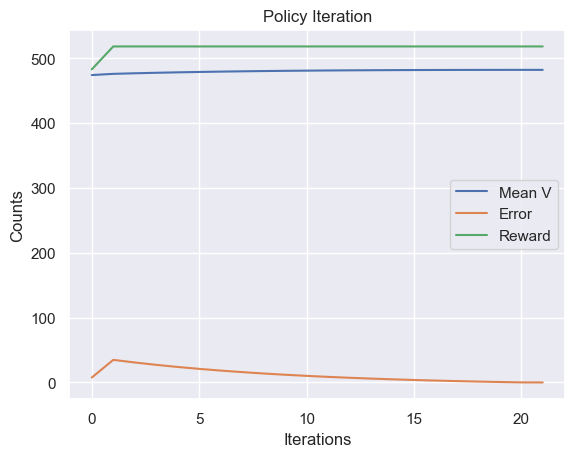

/var/folders/hm/psq79zp10blbxnxgz7xxgx0r0000gn/T/ipykernel_1161/145418701.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(gammas)


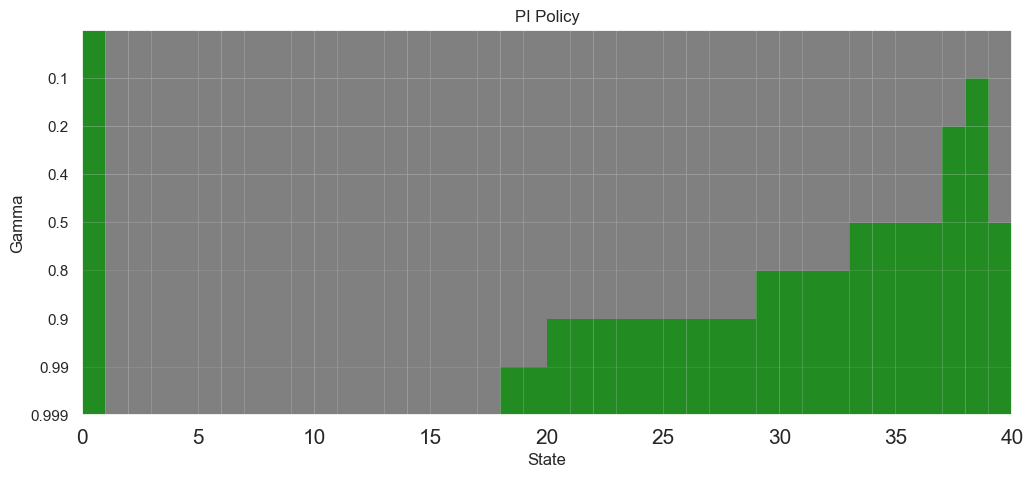

time  [0.03527188301086426]
t2 0.03527188301086426


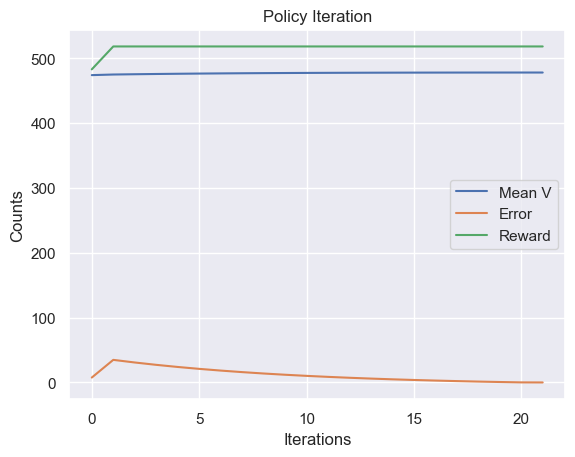

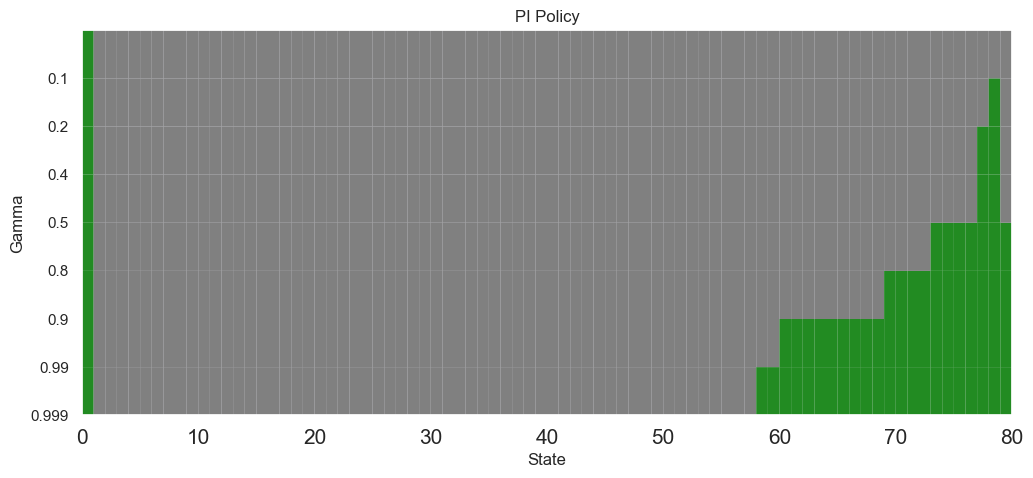

time  [0.03527188301086426, 0.04207587242126465]
t2 0.04207587242126465


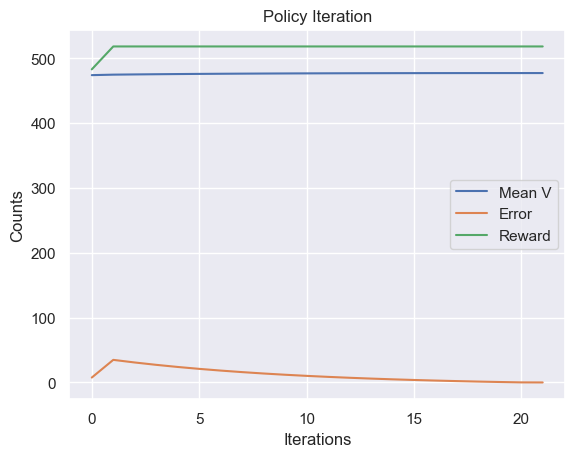

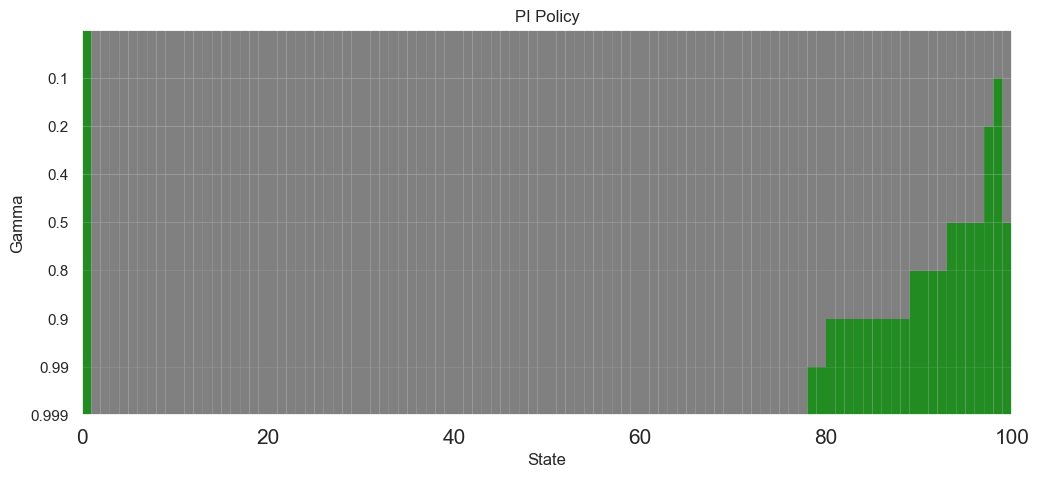

time  [0.03527188301086426, 0.04207587242126465, 0.029923439025878906]
t2 0.029923439025878906


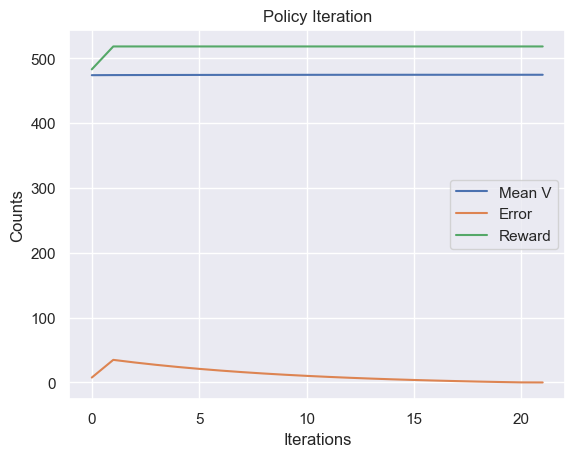

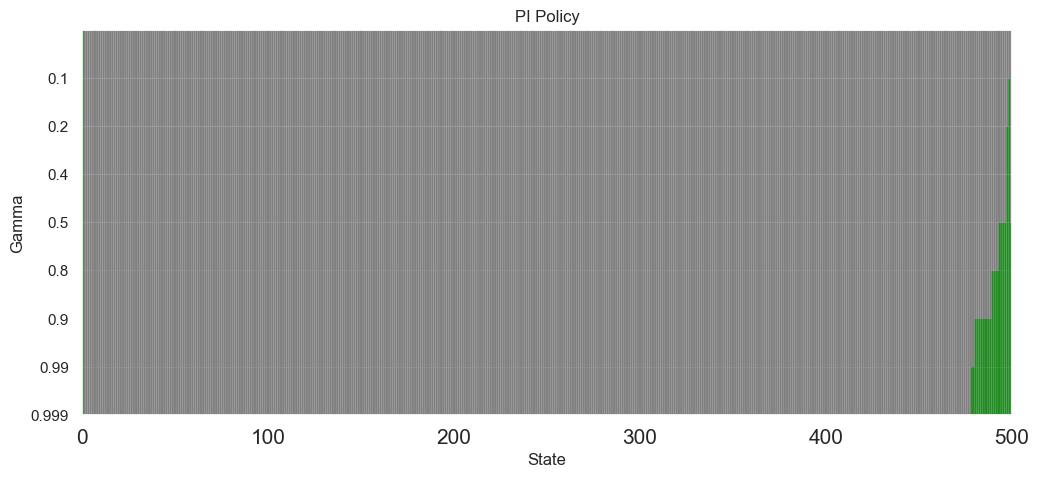

time  [0.03527188301086426, 0.04207587242126465, 0.029923439025878906, 0.7092621326446533]
t2 0.7092621326446533


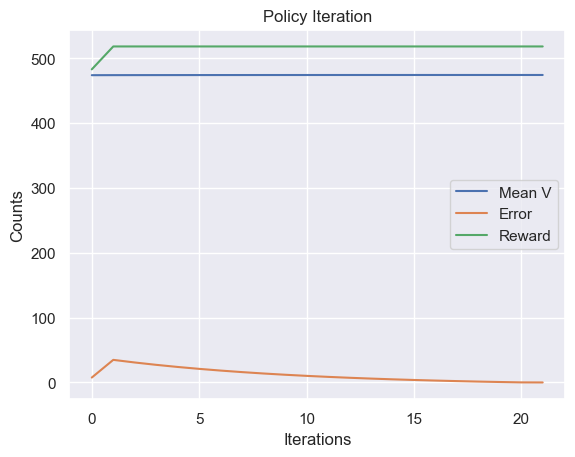

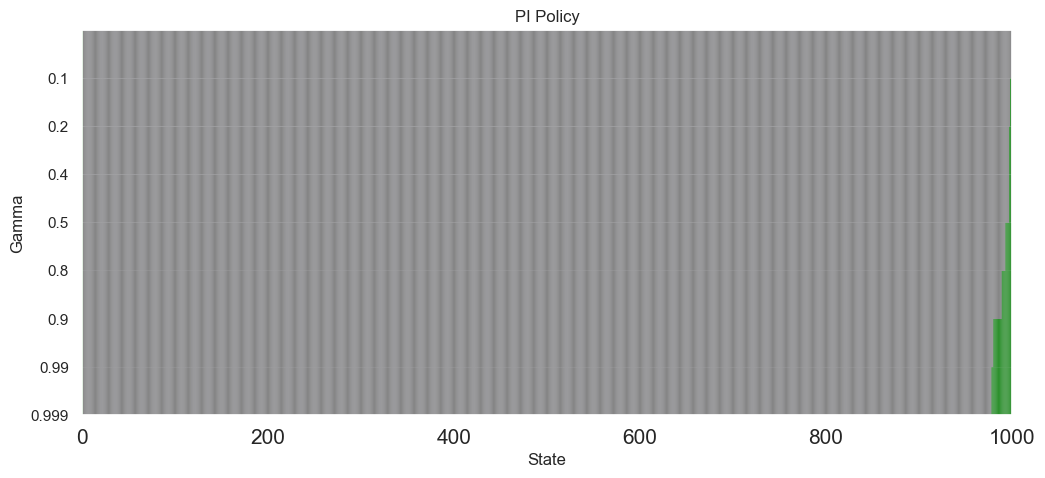

time  [0.03527188301086426, 0.04207587242126465, 0.029923439025878906, 0.7092621326446533, 1.530151128768921]
t2 1.530151128768921


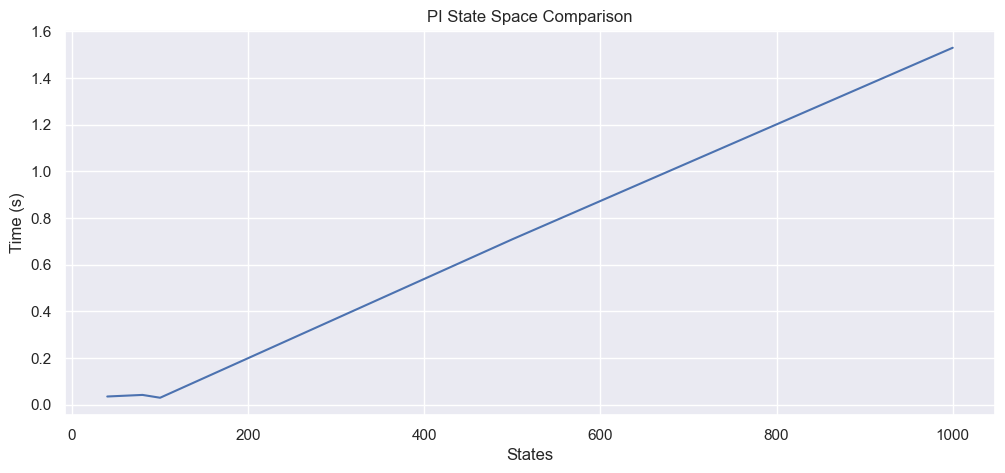

In [29]:
t, s = get_pi_state_comp()
plot_comparison(s, t, 'PI State Space Comparison')


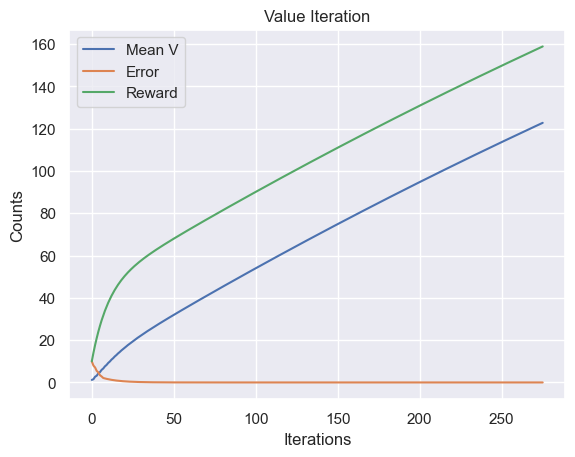

/var/folders/hm/psq79zp10blbxnxgz7xxgx0r0000gn/T/ipykernel_1161/643589763.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(gammas)


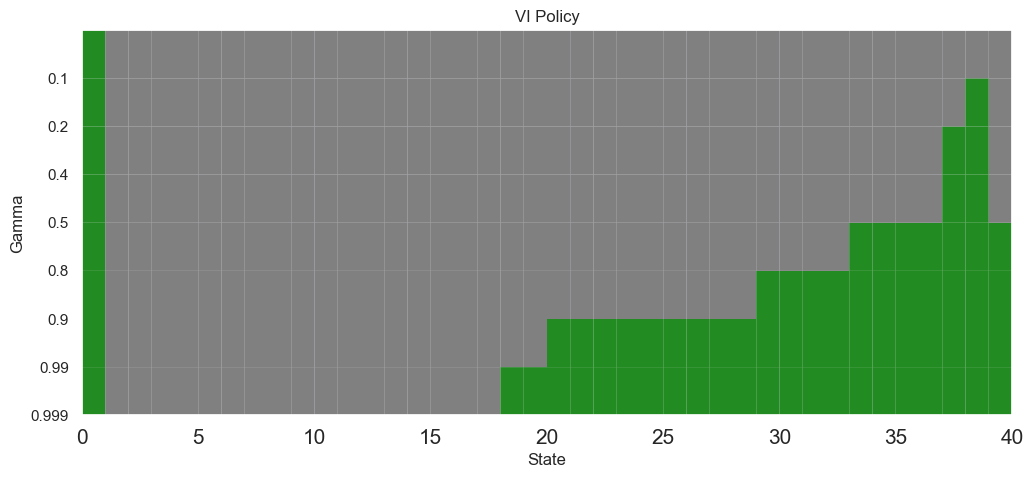

time  [0.07729697227478027]
t2 0.07729697227478027


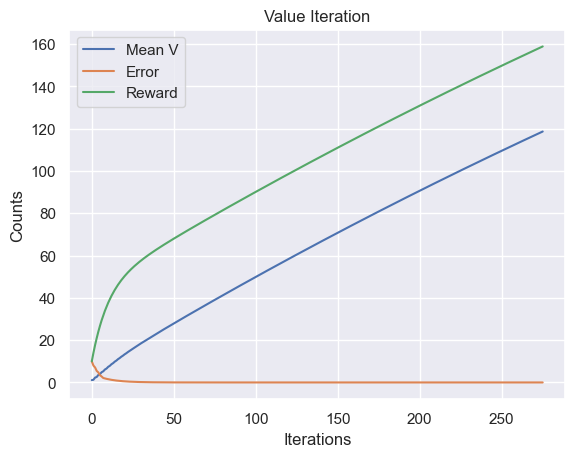

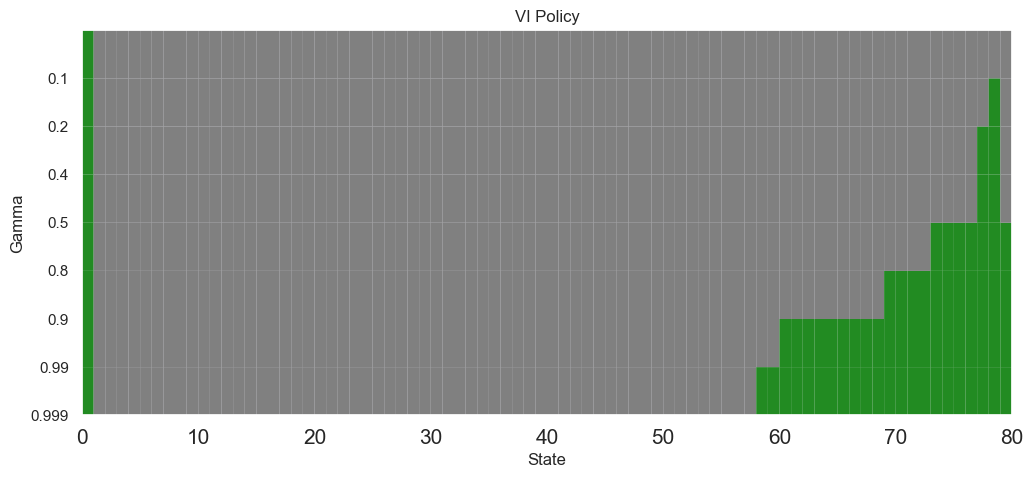

time  [0.07729697227478027, 0.08903241157531738]
t2 0.08903241157531738


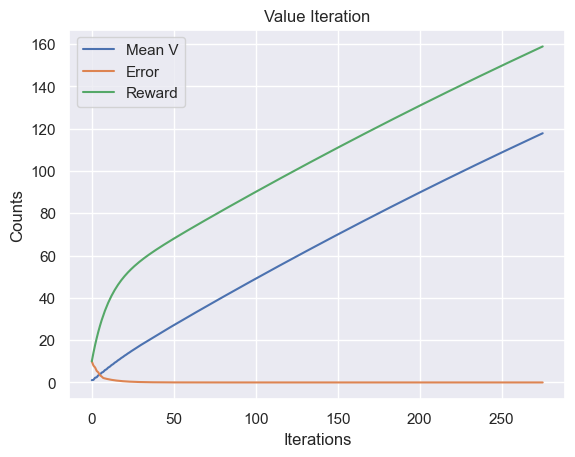

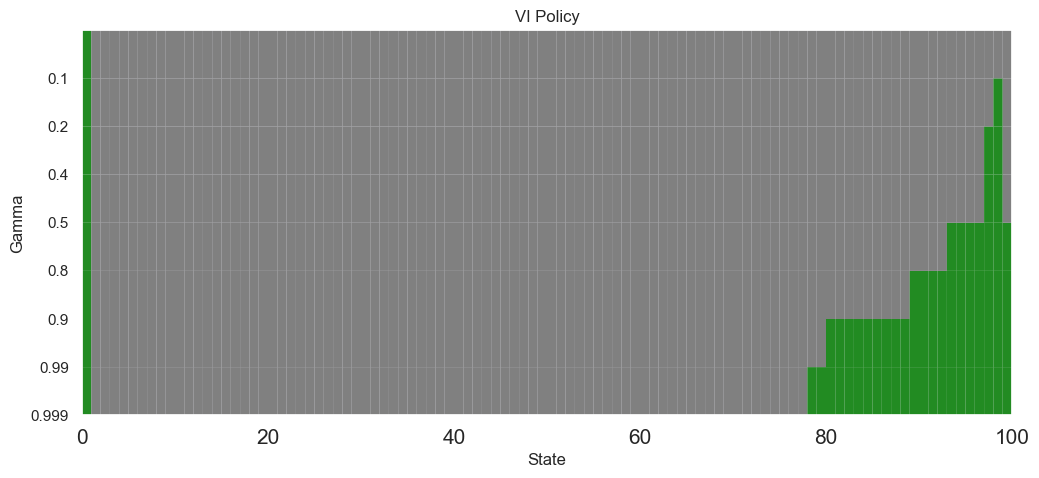

time  [0.07729697227478027, 0.08903241157531738, 0.3567798137664795]
t2 0.3567798137664795


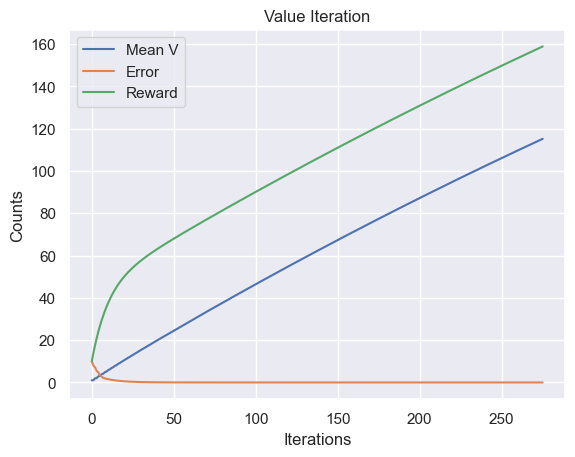

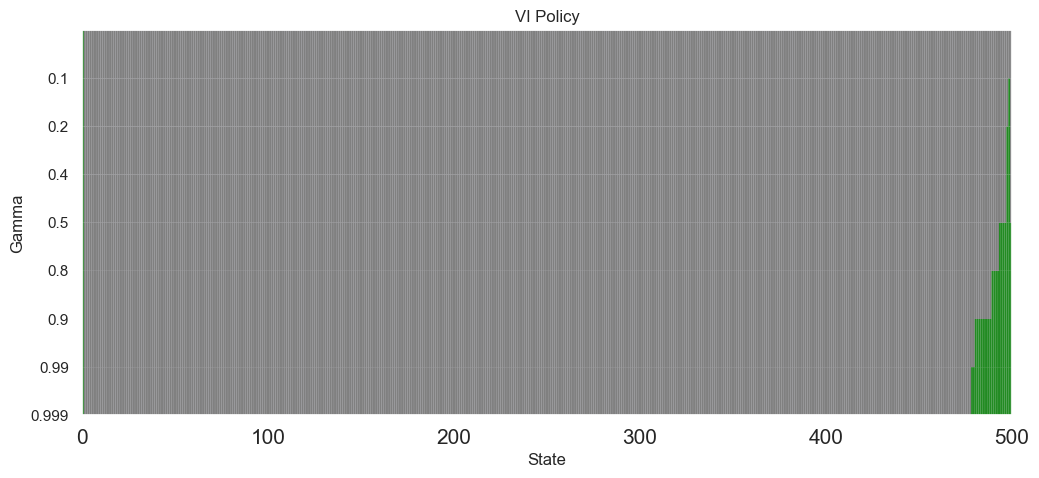

time  [0.07729697227478027, 0.08903241157531738, 0.3567798137664795, 0.5445034503936768]
t2 0.5445034503936768


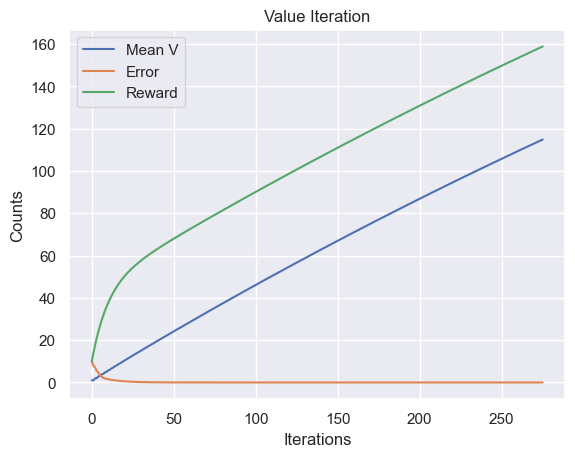

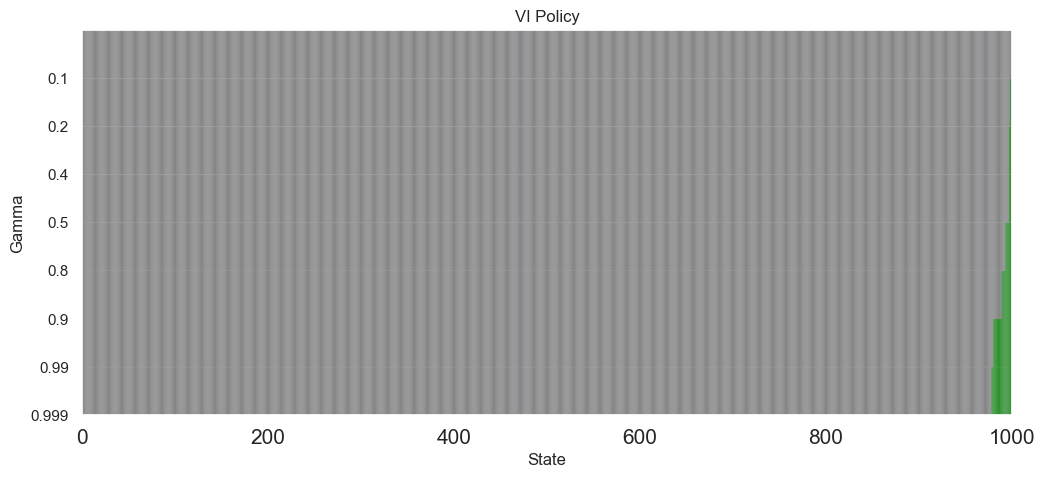

time  [0.07729697227478027, 0.08903241157531738, 0.3567798137664795, 0.5445034503936768, 0.8361308574676514]
t2 0.8361308574676514


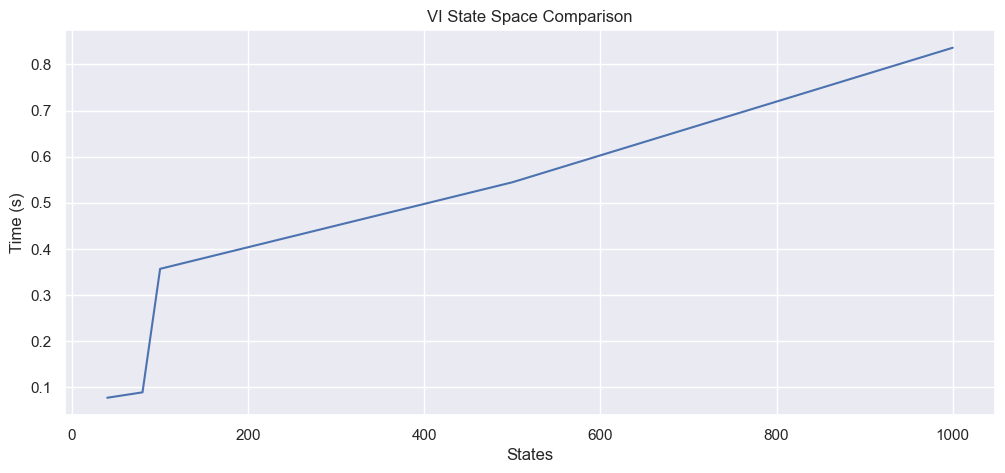

In [30]:
t, s = get_vi_state_comp()
plot_comparison(s, t, 'VI State Space Comparison')


### Q Learning

In [31]:
S = 400
p = 0.1
rewards = []
it = np.linspace(10000, 300000, 30)
time_arr = []

r1 = 5 #wait
r2 = 10  #cut
p = 0.1
P, R = mdptoolbox.example.forest(S=S, r1=r1, r2=r2, p=p) 

In [32]:


def run_episodes(policy, S, R, p, num_episodes, num_resets):
    rew_arr = []
    for y in range(num_resets):
        forest_state = 0
        tot_rew = 0
        for x in range(num_episodes):
            forest_state = min(forest_state, S - 1)
            if np.random.rand(1) <= p:
                forest_state = -1
            else:
                tot_rew += R[forest_state][policy[forest_state]]
                if policy[forest_state] == 1:
                    forest_state = -1
            forest_state += 1
        rew_arr.append(tot_rew)
    return np.mean(rew_arr)

In [33]:
def get_convergence_q_learn():
    
    best_e = 0.1
    best_ed = 0.999
    best_em = 1e-5
    best_a = 0.001
    best_ad = 1.0
    best_am = 1e-5
    best_g = 0.3

    for elem in it:
        st = time.time()
        
        Q_qlearning = mdp.QLearning(P, R, gamma=best_g, epsilon=best_e, epsilon_decay=best_ed,
                                                                    epsilon_min=best_em, n_iter=elem,
                                                                    alpha=best_a, alpha_min=best_am, alpha_decay=best_ad)
        Q_qlearning.run()
        rew = run_episodes(Q_qlearning.policy, S, R, p, 1000, 200)
        time_arr.append(time.time() - st)
        rewards.append(rew)
        
    
    return it, rewards, time_arr

In [34]:
def plot_convergence_q_learn():
    it, rew, time_arr = get_convergence_q_learn()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))


    sns.scatterplot(ax= axes[0], x=it, y=rew)
    sns.lineplot(ax= axes[0], x=it, y=rew)
    sns.scatterplot(ax= axes[1], x=it, y=time_arr)
    sns.lineplot(ax= axes[1], x=it, y=time_arr)





    axes[0].set(xlabel = 'Episodes', ylabel = 'Rewards', title= 'Convergence')
    axes[1].set(xlabel = 'Episodes', ylabel = 'Time(s)', title= 'Execution Time')

    plt.savefig(f'q_learning_convergence_fr.png')
    plt.show()

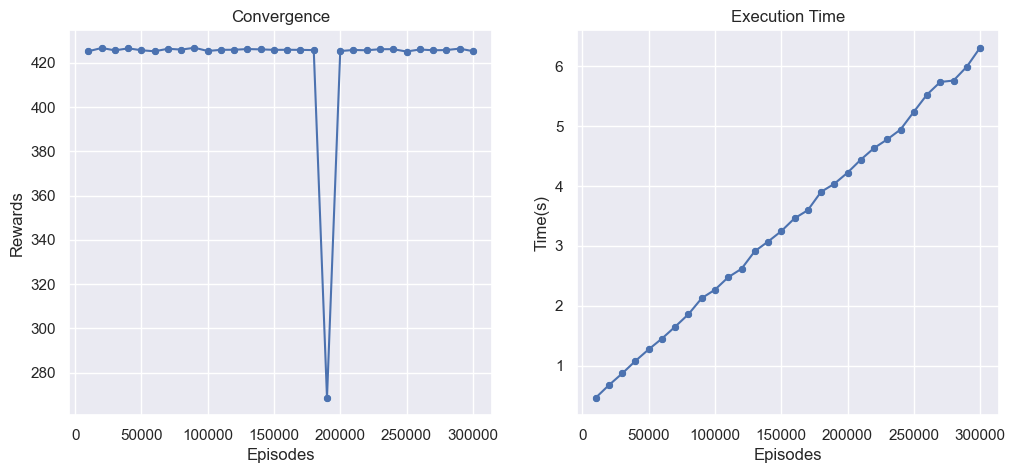

In [35]:
plot_convergence_q_learn()

In [36]:
def plot_state_space_comparison():
    
    
    S_val = [100, 400, 1000, 1500, 5000, 10000, 20000, 30000]
    time_arr = []
    r1 = 5  # The reward when the forest is in its oldest state and action ‘Wait’ is performed
    r2 = 10  # The reward when the forest is in its oldest state and action ‘Cut’ is performed
    p = 0.1

    for S in S_val:
        P, R = mdptoolbox.example.forest(S=S, r1=r1, r2=r2, p=p)  # Defaults left the same


        epsilon = 0.000001
        best_e = 1e-6
        best_ed = 0.99
        best_em = 1e-3
        best_a = 0.001
        best_ad = 0.99
        best_am = 0
        best_g = 0.1
        
        st = time.time()
        Q_qlearning = mdp.QLearning(P, R, gamma=best_g, epsilon=epsilon, epsilon_decay=best_ed,
                                                                    epsilon_min=best_em, n_iter=10000,
                                                                    alpha=best_a, alpha_min=best_am, alpha_decay=best_ad)
        Q_qlearning.run()
        rew = run_episodes(Q_qlearning.policy, S, R, p, 1000, 200)
        time_arr.append(time.time() - st)
        
    plt.figure()
    plt.scatter(S_val,time_arr)

    plt.xlabel('State Space Size')
    plt.ylabel('Time (s)')
    plt.savefig(f'q_learning_state_space_fr.png')
    plt.show()
    
    print(time_arr)

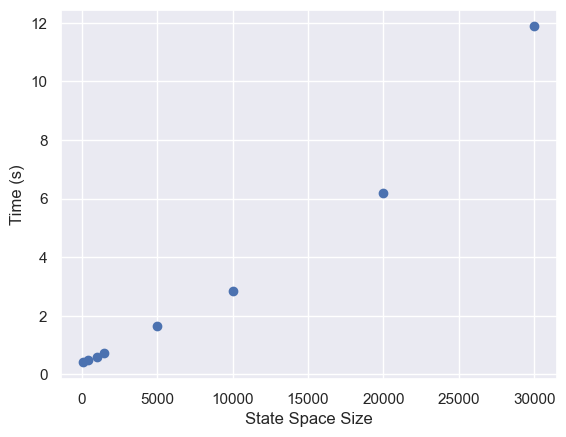

[0.4086301326751709, 0.4738750457763672, 0.5943150520324707, 0.7453701496124268, 1.6342101097106934, 2.8495020866394043, 6.183942794799805, 11.874014139175415]


In [37]:
plot_state_space_comparison()

In [44]:
def plot_best_policy():
    
    
    S = 1000
    r1 = 5 
    r2 = 10 
    p = 0.1

    P, R = mdptoolbox.example.forest(S=S, r1=r1, r2=r2, p=p) 

    
    epsilons = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
    best_pol_arr = []

    best_e = 1e-6
    best_ed = 0.99
    best_em = 1e-3
    best_a = 0.001
    best_ad = 0.99
    best_am = 0
    best_g = 0.1
    for epsilon in epsilons:
        Q_qlearning = mdp.QLearning(P, R, gamma=best_g, epsilon=epsilon, epsilon_decay=best_ed,
                                                                    epsilon_min=best_em, n_iter=10000,
                                                                    alpha=best_a, alpha_min=best_am, alpha_decay=best_ad)
        Q_qlearning.run()
        rew = run_episodes(Q_qlearning.policy, S, R, p, 1000, 200)

        best_pol_arr.append(Q_qlearning.policy)
        
    cmap = colors.ListedColormap(['forestgreen', 'red'])
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.title("Q Learner Optimal Policy")
    epsilons.reverse()

    plt.xticks()
    plt.xlabel('State')
    plt.ylabel('Epsilon')
    plt.pcolor(best_pol_arr[::-1], cmap=cmap, edgecolors='k', linewidths=0)
    ax.set_yticklabels(epsilons)
    ax.tick_params(left=False)
    plt.savefig('QL_Policy_fr.png')

/var/folders/hm/psq79zp10blbxnxgz7xxgx0r0000gn/T/ipykernel_1161/1388951220.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(epsilons)


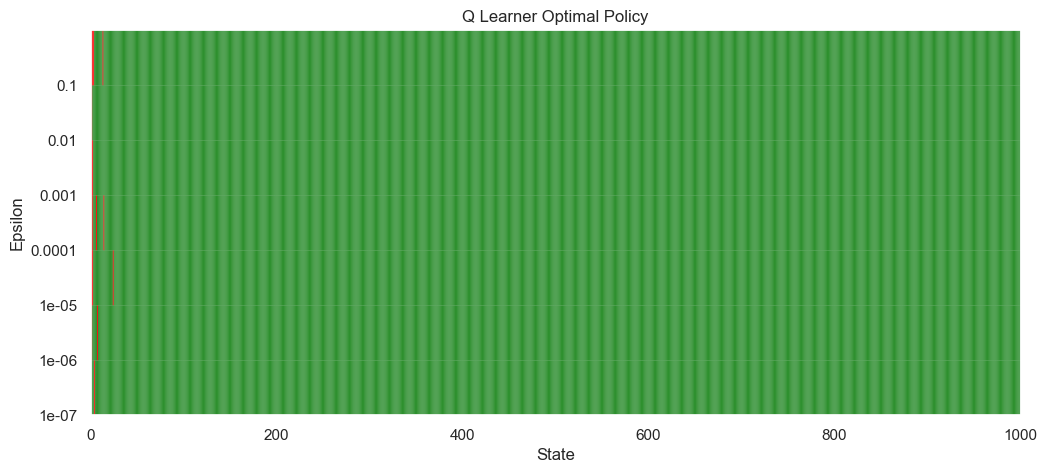

In [45]:
plot_best_policy()